In [33]:
import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [34]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    #size of labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #size of title
    plt.title(ax.get_title(), fontsize=16)

In [35]:
DATA_DIR = "/raid5pool/tank/luehring/german_newsguard_tweets/"
with open(join(DATA_DIR, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pickle.load(file)

In [36]:
df = pd.read_csv(join(DATA_DIR, 
                      "discussions/discussions_starters.csv.gz"), # including zero-replies
                         compression="gzip",
                         usecols=[
                           # tweet information
                           "id", 
                           "conversation_id", 
                           "domain",
                           "text",
                           "created_at",
                           "Score", "Rating", "Orientation",

                           # author information
                           "author_id",
                           "author.followers_count",
                           "author.following_count",
                           "author.tweet_count",

                           # starter or reply
                           "type",

                           # emotions
                           "anger", "fear", "disgust", "sadness",
                           "joy", "enthusiasm", "pride", "hope",
                           
                           # outcome measures
                           "reply_count",
                           "retweet_count",
                           "like_count",
                           "quote_count",
                           ],
                          dtype=DTYPES)

len(df)

9906260

In [37]:
df["type"].value_counts()

starter    9906260
Name: type, dtype: int64

In [38]:
# keep only starters
df = df[df["type"] == "starter"]
len(df)

9906260

In [39]:
df["Score"].describe()

count   9906259.000
mean         90.277
std          18.489
min           0.000
25%          92.500
50%          95.000
75%         100.000
max         100.000
Name: Score, dtype: float64

In [40]:
df["Rating"].value_counts(normalize=True)

T   0.940
N   0.060
S   0.000
Name: Rating, dtype: float64

In [41]:
df["domain"].nunique()

271

In [42]:
df["author_id"].nunique()

259502

In [43]:
df["Score"].mean()

90.27675846149388

In [44]:
df["Score"].std()

18.489391252151066

## Transform data

### Orientation

In [45]:
def recode_orientation(x):
    if pd.isna(x):
        return None
    elif "Neutral" in x:
        return 0
    elif "Right" in x:
        return 1
    elif "Left" in x:
        return -1
    else:
        return None
    
df["Orientation"] = \
    df["Orientation"].apply(recode_orientation)

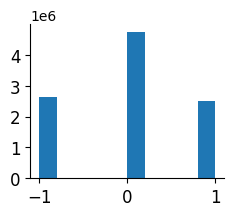

In [46]:
plt.figure(figsize=(2.5, 2))

df["Orientation"]\
    .hist()

custom_plots()

In [47]:
df["Orientation"].describe()

count   9906260.000
mean         -0.012
std           0.721
min          -1.000
25%          -1.000
50%           0.000
75%           1.000
max           1.000
Name: Orientation, dtype: float64

### Rating

In [48]:
def recode_rating(x):
    if pd.isna(x):
        return None
    elif "T" in x:
        return 0
    elif "N" in x:
        return 1
    else:
        return None
    
df["Rating"] = \
    df["Rating"]\
        .apply(recode_rating)

# drop missing values in Rating
df = df.dropna(subset=["Rating"])

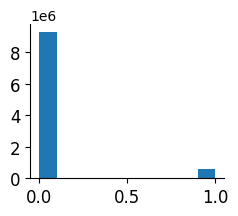

In [49]:
plt.figure(figsize=(2.5, 2))

df["Rating"]\
    .hist()

custom_plots()

### Word count

In [50]:
#calculate word count per initial tweet
df["word_count"] = \
    df["text"]\
        .apply(lambda x: len(x.split(" ")))

df["word_count"].describe()

count   9906259.000
mean         18.081
std           9.774
min           1.000
25%          10.000
50%          15.000
75%          26.000
max         230.000
Name: word_count, dtype: float64

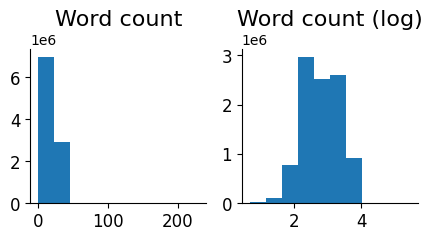

In [51]:
#log-transform word count
df["word_count_log"] = \
        np.log1p(df["word_count"])

# visualize both distributions in subplots next to each other
plt.figure(figsize=(5, 2))

plt.subplot(1, 2, 1)
df["word_count"]\
    .hist()
plt.title("Word count")
custom_plots()

plt.subplot(1, 2, 2)
df["word_count_log"]\
    .hist()
plt.title("Word count (log)")
custom_plots()

### Tweet count

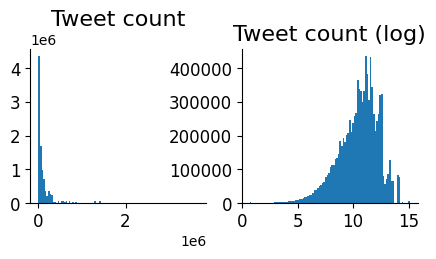

In [52]:
#distributions of follower count and log follower count
df["author.tweet_count_log"] = \
    np.log1p(df["author.tweet_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df["author.tweet_count"]\
    .hist(bins=100)
plt.title("Tweet count")
custom_plots()

plt.subplot(1, 2, 2)
df["author.tweet_count_log"]\
    .hist(bins=100)
plt.title("Tweet count (log)")
custom_plots()

### Follower count

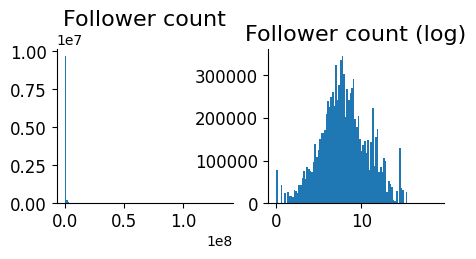

In [53]:
#distributions of follower count and log follower count
df["author.followers_count_log"] = \
    np.log1p(df["author.followers_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df["author.followers_count"]\
    .hist(bins=100)
plt.title("Follower count")
custom_plots()

plt.subplot(1, 2, 2)
df["author.followers_count_log"]\
    .hist(bins=100)
plt.title("Follower count (log)")
custom_plots()

### Following count

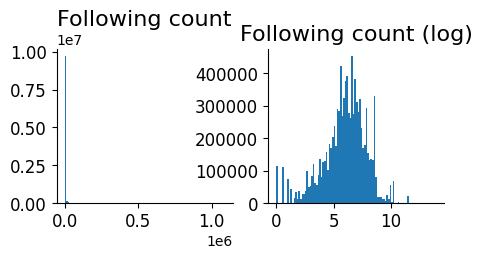

In [54]:
df["author.following_count_log"] = \
    np.log1p(df["author.following_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df["author.following_count"]\
    .hist(bins=100)
plt.title("Following count")
custom_plots()

plt.subplot(1, 2, 2)
df["author.following_count_log"]\
    .hist(bins=100)
plt.title("Following count (log)")
custom_plots()

### Emotions

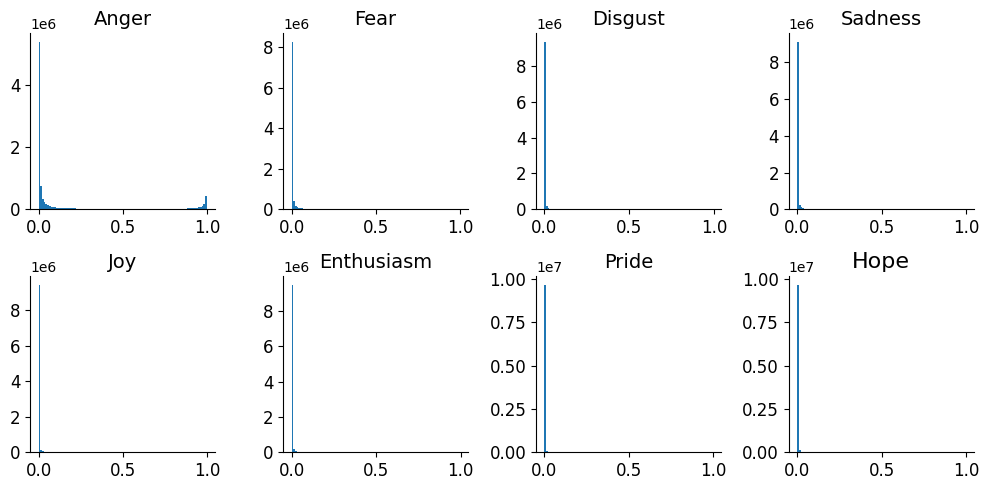

In [55]:
emotions = ["anger", "fear", "disgust", "sadness",
            "joy", "enthusiasm", "pride", "hope"]


fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()
for i, emotion in enumerate(emotions):
    ax = axes[i]  
    df[emotion].hist(bins=100, ax=ax) 
    ax.set_title(f'{emotion.capitalize()}', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    custom_plots(ax=ax)

plt.tight_layout()
plt.show()

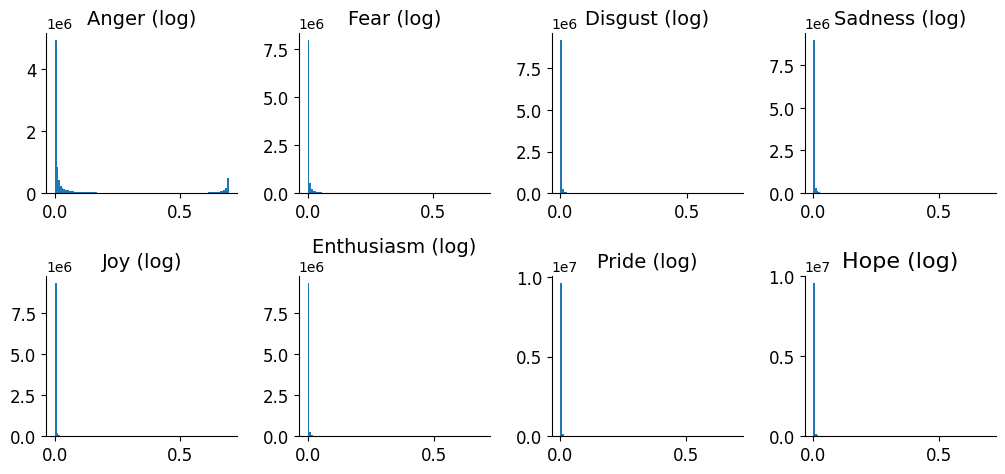

In [56]:
# log-transform the emotion scores
for emotion in emotions:
     df[f"{emotion}_log"] = \
          np.log1p(df[emotion])
     
# visualize the log-transformed emotion scores
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    df[f"{emotion}_log"].hist(bins=100, ax=ax)
    ax.set_title(f'{emotion.capitalize()} (log)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    custom_plots(ax=ax)

plt.tight_layout()
plt.show()

## Drop irrelevant data

In [57]:
len(df)

9906259

In [58]:
df.columns

Index(['id', 'domain', 'conversation_id', 'author_id', 'created_at', 'text',
       'reply_count', 'retweet_count', 'quote_count', 'like_count',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'enthusiasm', 'pride', 'hope', 'type', 'Orientation',
       'word_count', 'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'enthusiasm_log',
       'pride_log', 'hope_log'],
      dtype='object')

In [59]:
df = \
    df\
        .drop(columns=["conversation_id",
                        "text",
                        "enthusiasm", 
                        "enthusiasm_log",
                        "type"
                        ])

# df.head(3)

In [60]:
len(df)

9906259

In [ ]:
# are there any duplicated rows?
df\
    .duplicated()\
    .sum()

0

In [ ]:
df["Rating"].value_counts()

0.000    9310435
1.000     595824
Name: Rating, dtype: int64

## Save data for matching

In [ ]:
# df.to_csv(join(DATA_DIR,
#                 "discussions/discussions_starters_aggregates.csv"),
#                     index=False)